In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

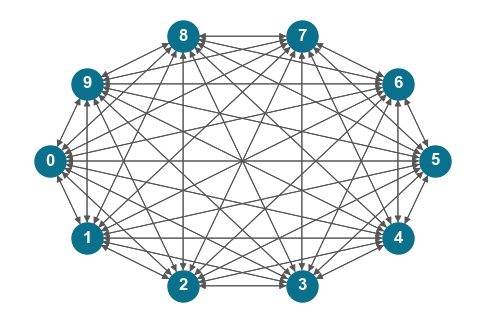

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

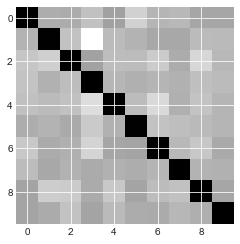

In [4]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


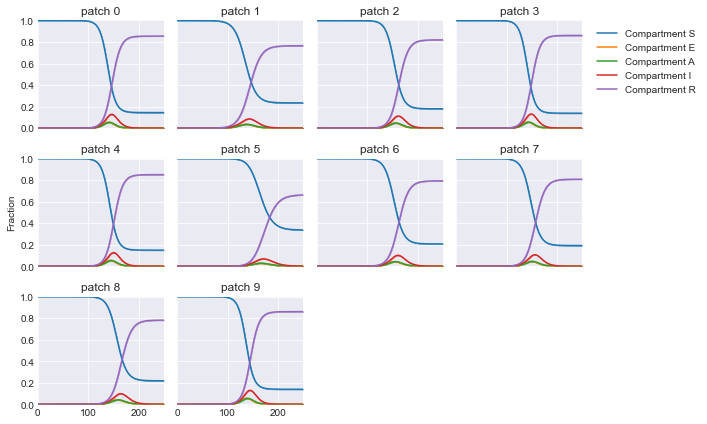

In [5]:
def gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/eta, 0)
    tmat.add_transition('A', 'I', 1/alpha, 0)
    tmat.add_transition('I', 'R', 1/mu, 0)
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [0, 180]
122 0.015657691 0.0334527774824479
73 3.4974753e-05 0.0
45 8.8457443e-07 0.007945232507143487
108 0.0028866034 0.01442355736609968
3 1.1672253e-11 0.0
115 0.0103614405 0.048952081556095116
66 2.0206047e-05 0.01900862218585365
24 4.1891177e-08 0.0017510667188805676
17 1.0552815e-08 0.0
38 2.9669027e-07 0.01716505239736926
171 0.030818883 0.03270556912915374
45 7.988033e-07 0.0
101 0.0019340848 0.0011484284439040055
129 0.06601216 0.04265028903508236
66 1.909915e-05 0.010484632361084694
17 8.088455e-09 0.0
122 0.0048208325 0.058085383813693145
157 0.10557671 0.11378249826150724
31 6.046642e-08 0.009713098335787616
17 6.7200525e-09 0.02623053766147473
59 3.5139087e-06 0.0
3 6.451803e-12 0.0
171 0.58774334 0.5720416112944946
136 0.03894579 0.006839909049684845
3 1.8099601e-10 0.0
129 0.0497725 0.0580935019170498
52 3.4130644e-06 0.0
38 5.0210974e-07 0.015624464143942097
108 0.0067300834 0.026914973994460332
143 0.32328814 0.3375559340915126
8

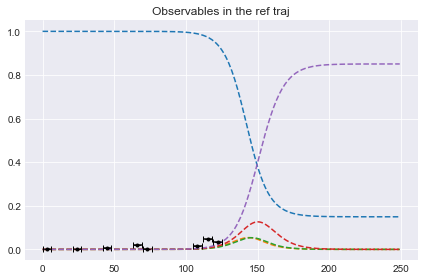

In [6]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.02, start_time=0, end_time=180)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [7]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 1, 1)
    tmat.add_transition('A', 'I', 3, 1)
    tmat.add_transition('I', 'R', 7, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = 0.005
    hyper_pram.beta_high = 0.05
    hyper_pram.beta_var = 0.03
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.80s/it]


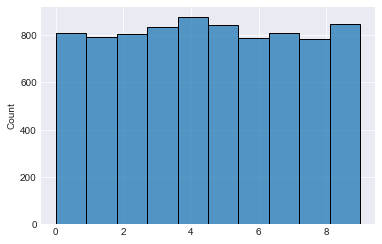

In [8]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [9]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


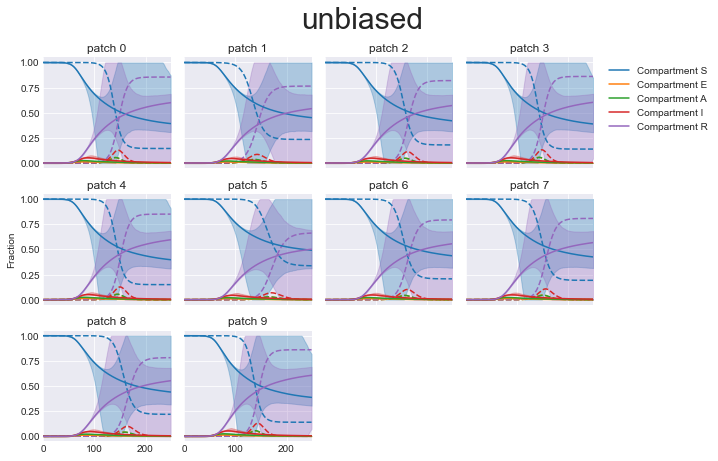

In [10]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0104 - weight-entropy: 6.9183
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0059 - weight-entropy: 6.8556
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0052 - weight-entropy: 6.7959
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0051 - weight-entropy: 6.7668
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0051 - weight-entropy: 6.7607
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 6.7665
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 6.7757
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0047 - weight-entropy: 6.7831
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 6.7867
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 6.1085
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0975
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0887
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0797
Epoch 83/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.0691
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.0591
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0535
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0468
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0321
Epoch 88/500
8/8 [==============================] - 0s 2ms/step - loss: 0.001

8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.5177
Epoch 157/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 5.5092
Epoch 158/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.5061
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4947
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4941
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4830
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4747
Epoch 163/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.4896
Epoch 164/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4776
Epoch 165/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 5.1929
Epoch 234/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 5.1705
Epoch 235/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.1594
Epoch 236/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 5.1593
Epoch 237/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 5.1758
Epoch 238/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.1377
Epoch 239/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.1316
Epoch 240/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.1366
Epoch 241/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.1492
Epoch 242/500
8/8 [==============================] - 0s 1ms/step - lo

8/8 [==============================] - 0s 1ms/step - loss: 9.9467e-04 - weight-entropy: 4.9376
Epoch 312/500
8/8 [==============================] - 0s 1ms/step - loss: 9.6502e-04 - weight-entropy: 4.9157
Epoch 313/500
8/8 [==============================] - 0s 2ms/step - loss: 9.6797e-04 - weight-entropy: 4.9040
Epoch 314/500
8/8 [==============================] - 0s 1ms/step - loss: 9.9143e-04 - weight-entropy: 4.9197
Epoch 315/500
8/8 [==============================] - 0s 2ms/step - loss: 9.6766e-04 - weight-entropy: 4.9226
Epoch 316/500
8/8 [==============================] - 0s 2ms/step - loss: 9.6497e-04 - weight-entropy: 4.9120
Epoch 317/500
8/8 [==============================] - 0s 2ms/step - loss: 9.3756e-04 - weight-entropy: 4.8740
Epoch 318/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.9268
Epoch 319/500
8/8 [==============================] - 0s 1ms/step - loss: 9.6477e-04 - weight-entropy: 4.8618
Epoch 320/500
8/8 [==================

8/8 [==============================] - 0s 2ms/step - loss: 7.7064e-04 - weight-entropy: 4.7218
Epoch 387/500
8/8 [==============================] - 0s 2ms/step - loss: 8.6098e-04 - weight-entropy: 4.7502
Epoch 388/500
8/8 [==============================] - 0s 2ms/step - loss: 7.8050e-04 - weight-entropy: 4.7214
Epoch 389/500
8/8 [==============================] - 0s 2ms/step - loss: 7.8211e-04 - weight-entropy: 4.7209
Epoch 390/500
8/8 [==============================] - 0s 2ms/step - loss: 8.5312e-04 - weight-entropy: 4.7463
Epoch 391/500
8/8 [==============================] - 0s 2ms/step - loss: 7.7539e-04 - weight-entropy: 4.7116
Epoch 392/500
8/8 [==============================] - 0s 2ms/step - loss: 7.4985e-04 - weight-entropy: 4.7119
Epoch 393/500
8/8 [==============================] - 0s 2ms/step - loss: 7.9861e-04 - weight-entropy: 4.7385
Epoch 394/500
8/8 [==============================] - 0s 2ms/step - loss: 8.1855e-04 - weight-entropy: 4.7248
Epoch 395/500
8/8 [==============

8/8 [==============================] - 0s 1ms/step - loss: 7.0836e-04 - weight-entropy: 4.5927
Epoch 462/500
8/8 [==============================] - 0s 1ms/step - loss: 7.4934e-04 - weight-entropy: 4.6536
Epoch 463/500
8/8 [==============================] - 0s 2ms/step - loss: 6.6545e-04 - weight-entropy: 4.5944
Epoch 464/500
8/8 [==============================] - 0s 2ms/step - loss: 6.9585e-04 - weight-entropy: 4.5500
Epoch 465/500
8/8 [==============================] - 0s 2ms/step - loss: 7.3536e-04 - weight-entropy: 4.6102
Epoch 466/500
8/8 [==============================] - 0s 2ms/step - loss: 6.9088e-04 - weight-entropy: 4.5740
Epoch 467/500
8/8 [==============================] - 0s 2ms/step - loss: 7.2443e-04 - weight-entropy: 4.5692
Epoch 468/500
8/8 [==============================] - 0s 2ms/step - loss: 7.6471e-04 - weight-entropy: 4.6516
Epoch 469/500
8/8 [==============================] - 0s 2ms/step - loss: 7.0946e-04 - weight-entropy: 4.5960
Epoch 470/500
8/8 [==============

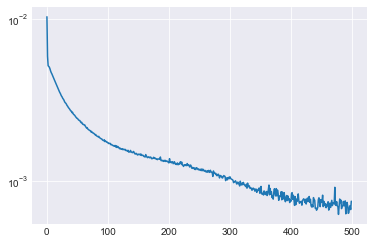

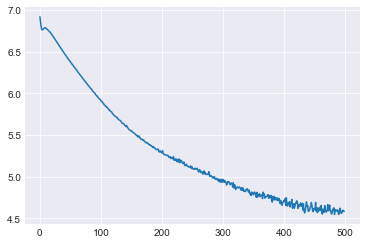

In [11]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [12]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


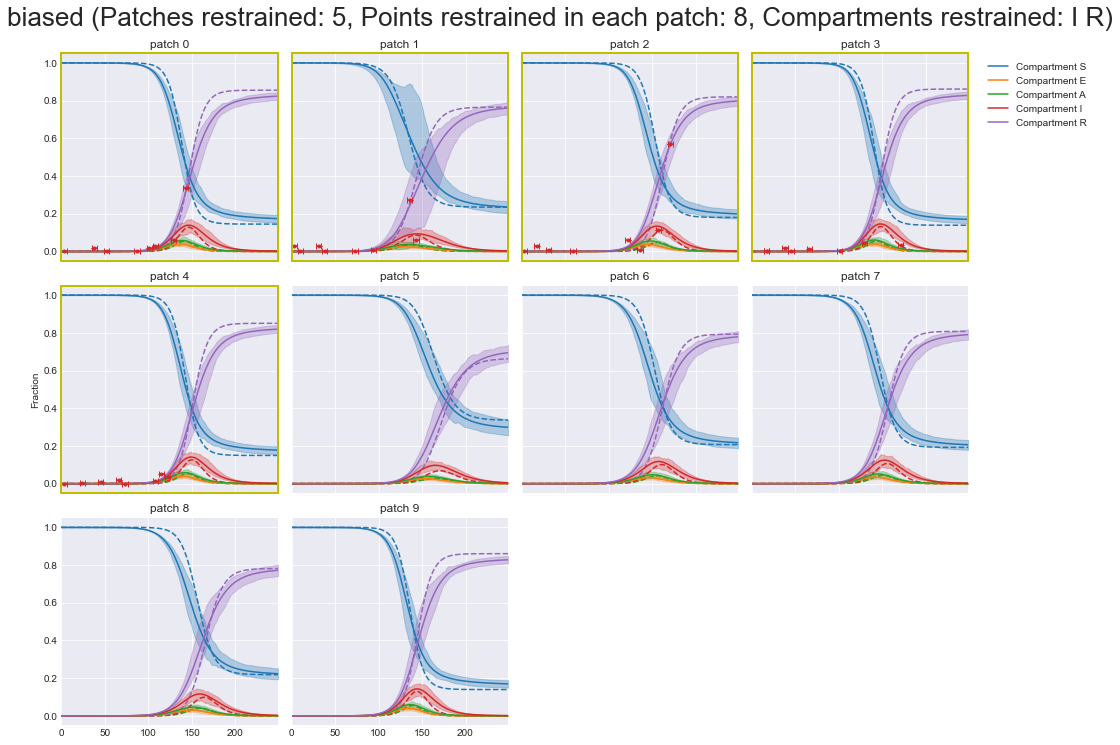

In [13]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

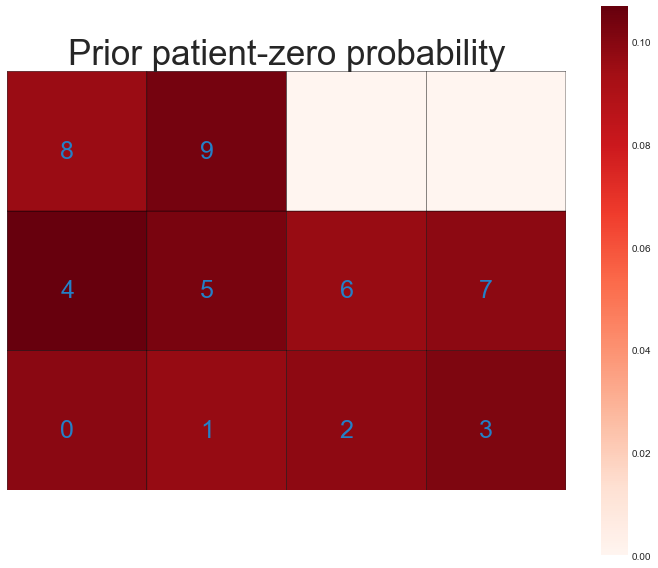

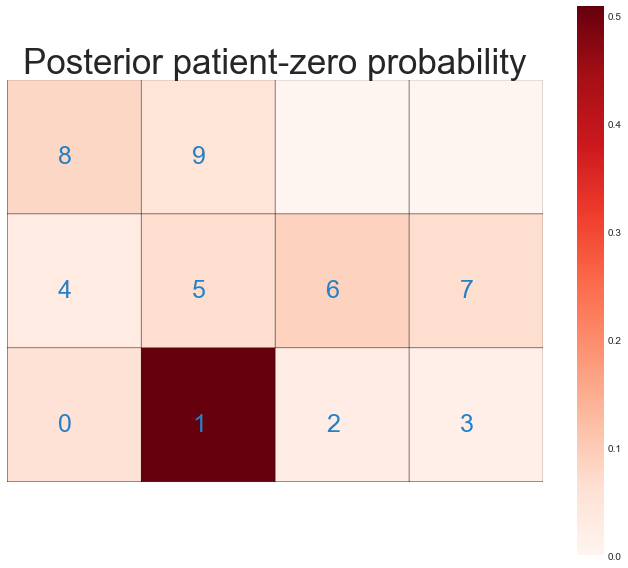

In [14]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

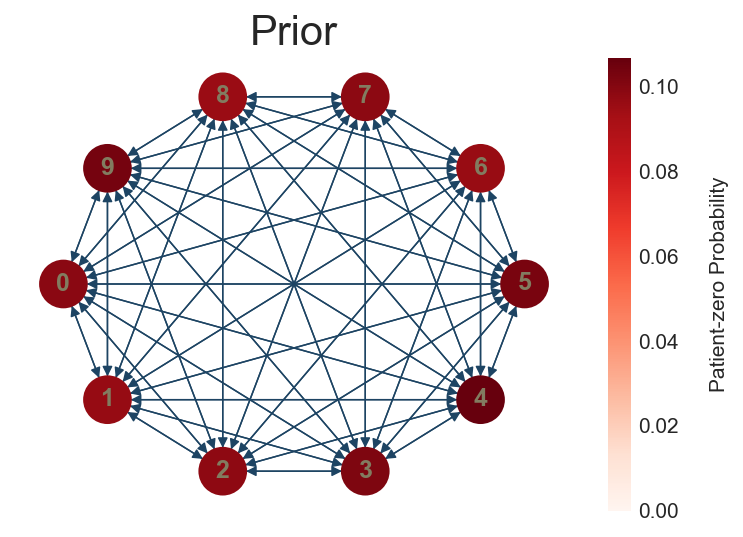

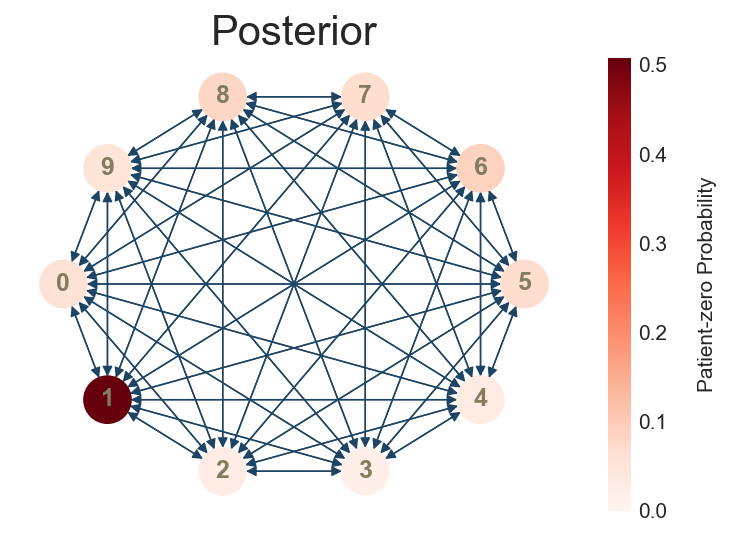

In [15]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [16]:
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.5083970815227632, 'patch 1'), (0.08909130476413536, 'patch 6'), (0.08126390392369426, 'patch 8'), (0.06833526212093277, 'patch 5'), (0.06807186920646369, 'patch 7')]


 # Case 2

6.9

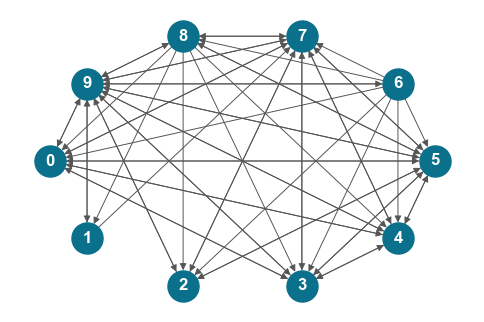

In [17]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [18]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


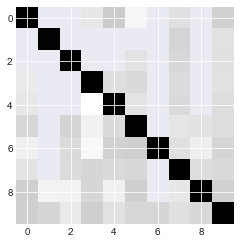

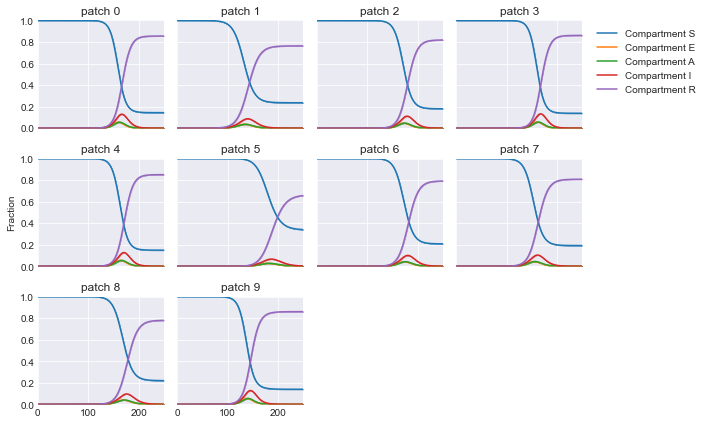

In [19]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250,
                               population=population, area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
52 6.214541e-08 0.019260000372618487
45 2.0701155e-08 0.03180134771167414
136 0.0070084697 0.01935309426440983
115 0.00045135882 0.0
101 9.254576e-05 0.0
52 7.145145e-08 0.01886528595084265
171 0.4164996 0.4314433813996688
129 0.0040604295 0.0
52 3.284461e-07 0.0
66 1.7823071e-06 0.0
45 1.3770757e-07 0.0
80 9.344281e-06 0.0031434213867995208
108 0.00039950406 0.022948961661918767
143 0.02221936 0.07791802117119889
10 2.809025e-10 0.0
73 6.423713e-06 0.0
136 0.011141318 0.02878001697793872
157 0.09472687 0.09882712972818426
24 6.223973e-10 0.024227270767601203
3 3.5515335e-13 0.0
136 0.016082974 0.03324145263662359
115 0.00096151006 0.023783547390246906
38 8.53462e-09 0.029331582846103675
31 2.189525e-09 0.017051040978749647
3 3.76237e-13 0.0
66 3.6977676e-07 0.016006328763557322
80 2.5390489e-06 0.0
122 0.0006134966 0.0
80 3.434005e-06 0.03861638839179332
24 3.6086437e-10 0.003972130621980911
136 0.0052655563 0.0023494112239783238
108 0.0

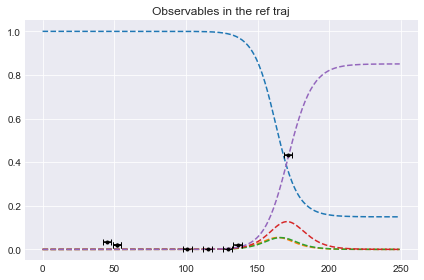

In [20]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:32<00:00,  2.03s/it]


Plotting 10 patches in a 3 x 4 grid


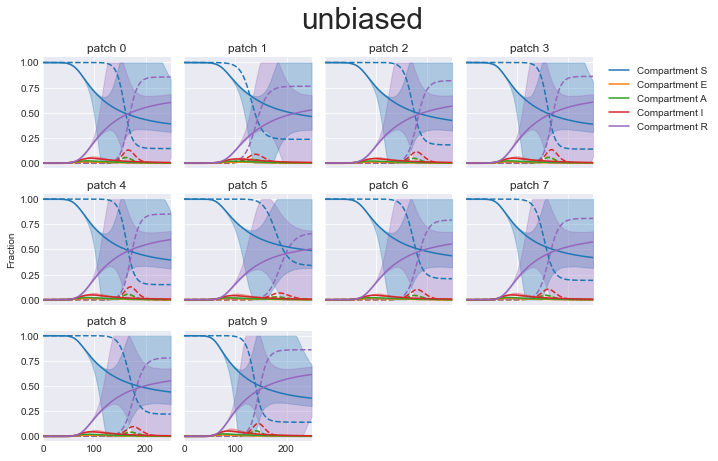

In [21]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0155 - weight-entropy: 6.9156
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0065 - weight-entropy: 6.8404
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 6.7602
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 6.7051
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 6.6721
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 6.6532
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 6.6425
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 6.6363
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 6.6329
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2639
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2567
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2499
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2449
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9454e-04 - weight-entropy: 6.2378
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 9.8617e-04 - weight-entropy: 6.2311
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 9.8342e-04 - weight-entropy: 6.2266
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 9.6980e-04 - weight-entropy: 6.2193
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 9.6461e-04 - weight-entropy: 6.2129
Epoch 88/500
8/8 [==============================] - 0s 2m

8/8 [==============================] - 0s 2ms/step - loss: 6.1774e-04 - weight-entropy: 5.8326
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 6.1039e-04 - weight-entropy: 5.8275
Epoch 156/500
8/8 [==============================] - 0s 2ms/step - loss: 6.2818e-04 - weight-entropy: 5.8255
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0572e-04 - weight-entropy: 5.8117
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0155e-04 - weight-entropy: 5.8084
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0605e-04 - weight-entropy: 5.8038
Epoch 160/500
8/8 [==============================] - 0s 1ms/step - loss: 6.0966e-04 - weight-entropy: 5.8028
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0157e-04 - weight-entropy: 5.8003
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 6.1160e-04 - weight-entropy: 5.7973
Epoch 163/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 4.9018e-04 - weight-entropy: 5.5328
Epoch 230/500
8/8 [==============================] - 0s 1ms/step - loss: 4.7432e-04 - weight-entropy: 5.5361
Epoch 231/500
8/8 [==============================] - 0s 1ms/step - loss: 5.0353e-04 - weight-entropy: 5.5334
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 4.8549e-04 - weight-entropy: 5.5309
Epoch 233/500
8/8 [==============================] - 0s 1ms/step - loss: 4.6624e-04 - weight-entropy: 5.5252
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 5.1310e-04 - weight-entropy: 5.5488
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 4.8134e-04 - weight-entropy: 5.5202
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 4.6295e-04 - weight-entropy: 5.5101
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 4.6661e-04 - weight-entropy: 5.5107
Epoch 238/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 4.1663e-04 - weight-entropy: 5.3646
Epoch 304/500
8/8 [==============================] - 0s 2ms/step - loss: 4.2551e-04 - weight-entropy: 5.3667
Epoch 305/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0412e-04 - weight-entropy: 5.3575
Epoch 306/500
8/8 [==============================] - 0s 2ms/step - loss: 4.2823e-04 - weight-entropy: 5.3759
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4334e-04 - weight-entropy: 5.3819
Epoch 308/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0681e-04 - weight-entropy: 5.3541
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 4.4535e-04 - weight-entropy: 5.3732
Epoch 310/500
8/8 [==============================] - 0s 2ms/step - loss: 4.2531e-04 - weight-entropy: 5.3480
Epoch 311/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4430e-04 - weight-entropy: 5.3596
Epoch 312/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.8031e-04 - weight-entropy: 5.2744
Epoch 378/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9359e-04 - weight-entropy: 5.2707
Epoch 379/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0991e-04 - weight-entropy: 5.2827
Epoch 380/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9286e-04 - weight-entropy: 5.2713
Epoch 381/500
8/8 [==============================] - 0s 2ms/step - loss: 4.3227e-04 - weight-entropy: 5.2914
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7130e-04 - weight-entropy: 5.2498
Epoch 383/500
8/8 [==============================] - 0s 2ms/step - loss: 4.3457e-04 - weight-entropy: 5.2935
Epoch 384/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7914e-04 - weight-entropy: 5.2573
Epoch 385/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9918e-04 - weight-entropy: 5.2787
Epoch 386/500
8/8 [==============

8/8 [==============================] - 0s 1ms/step - loss: 3.7936e-04 - weight-entropy: 5.2090
Epoch 452/500
8/8 [==============================] - 0s 2ms/step - loss: 3.5133e-04 - weight-entropy: 5.1989
Epoch 453/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1211e-04 - weight-entropy: 5.2228
Epoch 454/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7950e-04 - weight-entropy: 5.2136
Epoch 455/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0515e-04 - weight-entropy: 5.2277
Epoch 456/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8029e-04 - weight-entropy: 5.1973
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7476e-04 - weight-entropy: 5.2024
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8561e-04 - weight-entropy: 5.2138
Epoch 459/500
8/8 [==============================] - 0s 1ms/step - loss: 3.7295e-04 - weight-entropy: 5.2042
Epoch 460/500
8/8 [==============

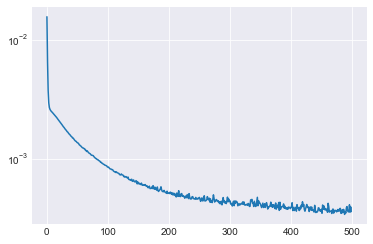

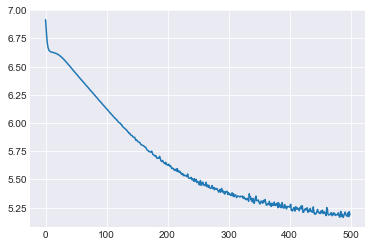

In [22]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


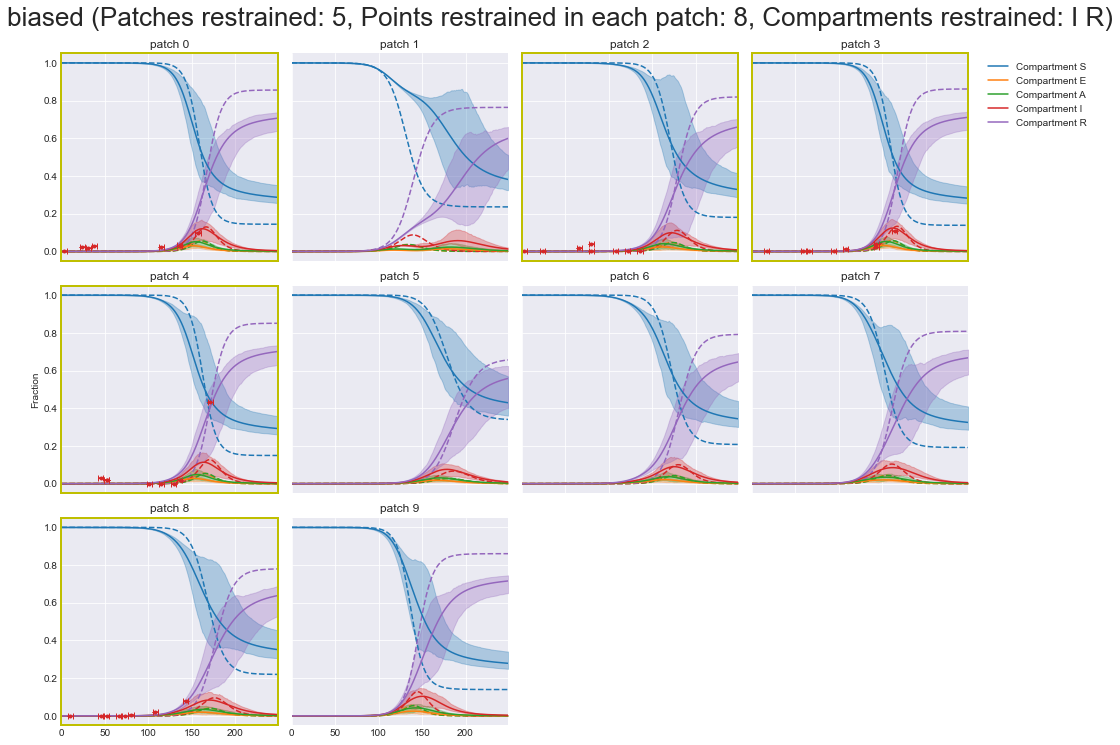

In [23]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

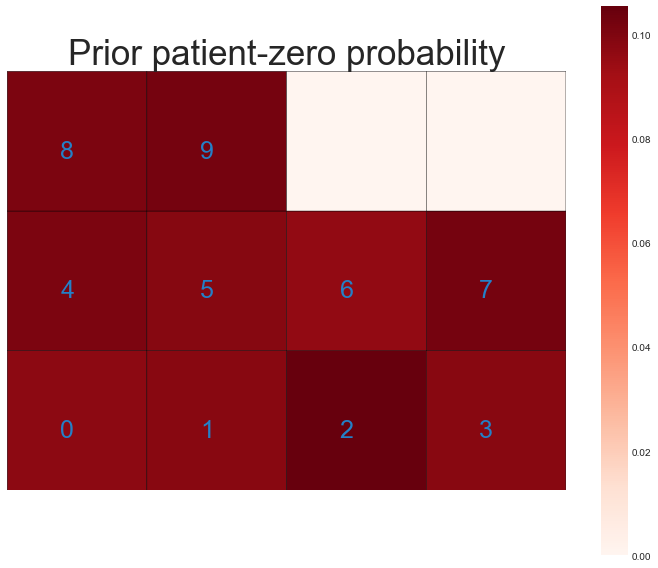

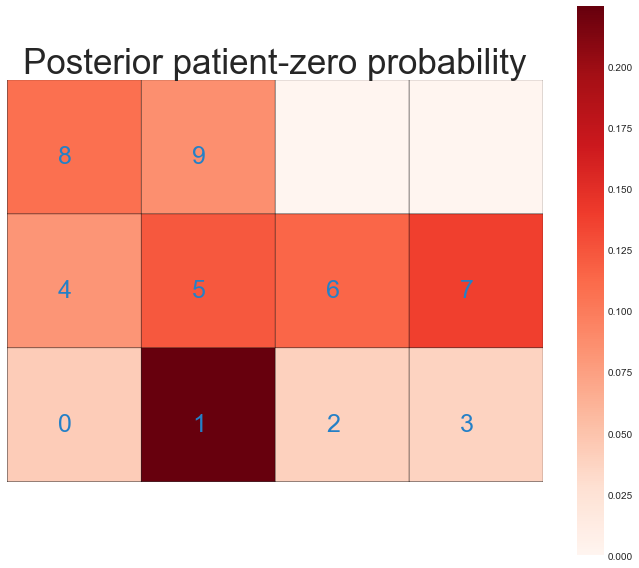

In [24]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

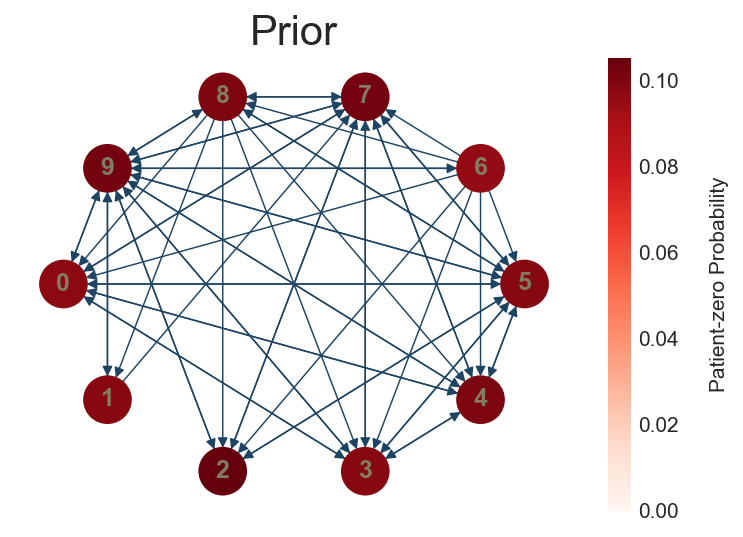

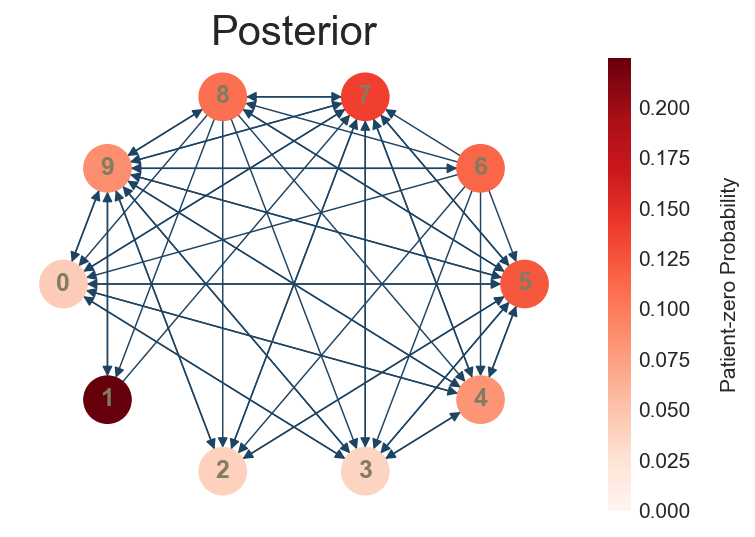

In [25]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [26]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.2248040389463601, 'patch 1'), (0.1387343034601385, 'patch 7'), (0.12328178603746143, 'patch 5'), (0.11445258393776037, 'patch 6'), (0.10841900464266341, 'patch 8')]


# Case 3

4.5

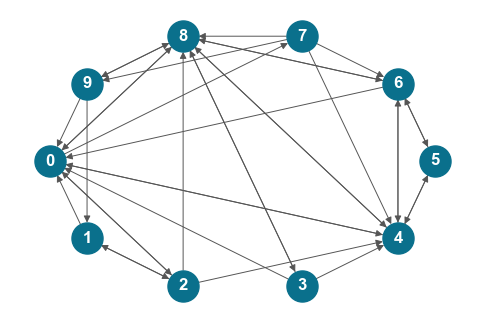

In [27]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


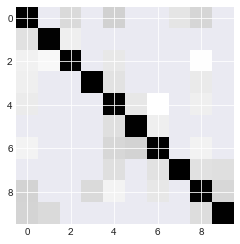

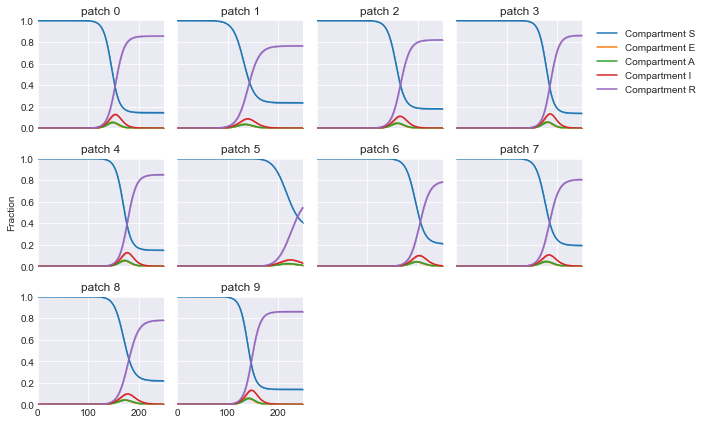

In [28]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
31 1.3212618e-05 0.0
94 0.004969315 0.0
136 0.084948264 0.11587317519449736
87 0.0026006703 0.005091603219178076
73 0.0014113747 0.05533585570961777
101 0.019469088 0.017990594617826414
24 1.1907549e-05 0.0
129 0.20239803 0.19211335263119717
115 2.4001022e-06 0.0
3 8.053299e-18 0.0
164 0.0014945589 0.0003958575319637902
59 6.354147e-10 0.0
73 6.725298e-09 0.0
31 2.8437517e-12 0.0006804484468202755
164 0.0022797468 0.008873499652421511
129 2.2229748e-05 0.01411666760310308
73 1.22148795e-05 0.0
59 2.2343822e-06 0.0
164 0.10996985 0.10390326860217249
108 0.00074503187 0.0
94 0.00023362073 0.0
31 6.986162e-08 0.0029949383180056495
143 0.062440254 0.06378123784175
38 1.9948597e-07 0.0
80 1.2487574e-06 0.0007413631955742767
101 2.2174137e-05 0.015380222292138472
129 0.00088903535 0.012686631763936505
115 0.00014346484 0.0
24 1.0476253e-10 0.0
66 2.1078063e-07 0.03592701295189383
73 5.9358626e-07 0.0
108 7.849685e-05 0.0
80 1.413429e-06 0.00401

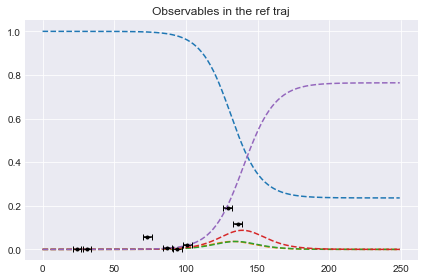

In [29]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:35<00:00,  2.21s/it]


Plotting 10 patches in a 3 x 4 grid


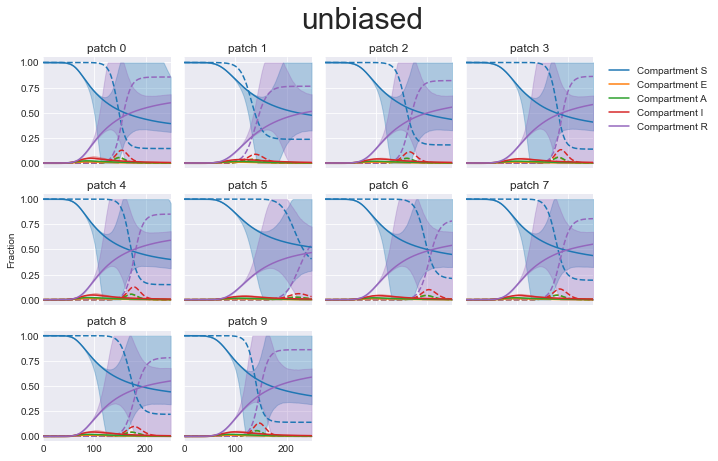

In [30]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0099 - weight-entropy: 6.9217
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 6.8729
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 6.8164
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 6.7715
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 6.7394
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.7169
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 6.7000
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 6.6870
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 6.6765
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5767
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5767
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5770
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5772
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5774
Epoch 84/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5775
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 6.5776
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 6.5780
Epoch 87/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 6.5782
Epoch 88/500
8/8 [==============================] - 0s 2ms/step - loss: 0.001

8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4797
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4753
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4717
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4671
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4627
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4585
Epoch 163/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4543
Epoch 164/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.4498
Epoch 165/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9957e-04 - weight-entropy: 6.4455
Epoch 166/500
8/8 [==============================] - 0s 2ms/step 

8/8 [==============================] - 0s 2ms/step - loss: 6.0645e-04 - weight-entropy: 5.9927
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 6.3589e-04 - weight-entropy: 5.9890
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 6.2354e-04 - weight-entropy: 5.9780
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0529e-04 - weight-entropy: 5.9690
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 5.9883e-04 - weight-entropy: 5.9594
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 5.9015e-04 - weight-entropy: 5.9444
Epoch 238/500
8/8 [==============================] - 0s 2ms/step - loss: 5.8310e-04 - weight-entropy: 5.9373
Epoch 239/500
8/8 [==============================] - 0s 2ms/step - loss: 5.8456e-04 - weight-entropy: 5.9305
Epoch 240/500
8/8 [==============================] - 0s 2ms/step - loss: 5.7605e-04 - weight-entropy: 5.9122
Epoch 241/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.8306e-04 - weight-entropy: 5.2886
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 3.5895e-04 - weight-entropy: 5.2319
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 3.9055e-04 - weight-entropy: 5.2800
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 3.5951e-04 - weight-entropy: 5.2208
Epoch 310/500
8/8 [==============================] - 0s 1ms/step - loss: 3.7917e-04 - weight-entropy: 5.2497
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 3.6601e-04 - weight-entropy: 5.2168
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8777e-04 - weight-entropy: 5.2573
Epoch 313/500
8/8 [==============================] - 0s 1ms/step - loss: 3.5731e-04 - weight-entropy: 5.1732
Epoch 314/500
8/8 [==============================] - 0s 2ms/step - loss: 3.5788e-04 - weight-entropy: 5.1729
Epoch 315/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.0910e-04 - weight-entropy: 4.8642
Epoch 381/500
8/8 [==============================] - 0s 2ms/step - loss: 2.9981e-04 - weight-entropy: 4.8670
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 2.9807e-04 - weight-entropy: 4.8197
Epoch 383/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0251e-04 - weight-entropy: 4.8124
Epoch 384/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1491e-04 - weight-entropy: 4.8139
Epoch 385/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1651e-04 - weight-entropy: 4.7941
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1757e-04 - weight-entropy: 4.8193
Epoch 387/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2105e-04 - weight-entropy: 4.8356
Epoch 388/500
8/8 [==============================] - 0s 2ms/step - loss: 2.9536e-04 - weight-entropy: 4.7918
Epoch 389/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.0264e-04 - weight-entropy: 4.7498
Epoch 455/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0802e-04 - weight-entropy: 4.7082
Epoch 456/500
8/8 [==============================] - 0s 2ms/step - loss: 2.8360e-04 - weight-entropy: 4.6385
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2858e-04 - weight-entropy: 4.7445
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6179e-04 - weight-entropy: 4.6103
Epoch 459/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0043e-04 - weight-entropy: 4.7252
Epoch 460/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0172e-04 - weight-entropy: 4.6665
Epoch 461/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2651e-04 - weight-entropy: 4.7319
Epoch 462/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0283e-04 - weight-entropy: 4.7209
Epoch 463/500
8/8 [==============

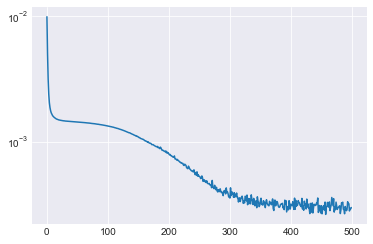

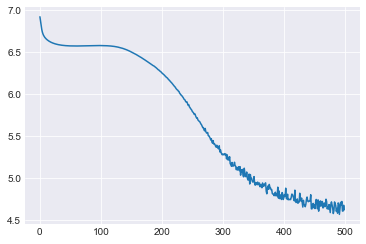

In [31]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

Plotting 10 patches in a 3 x 4 grid


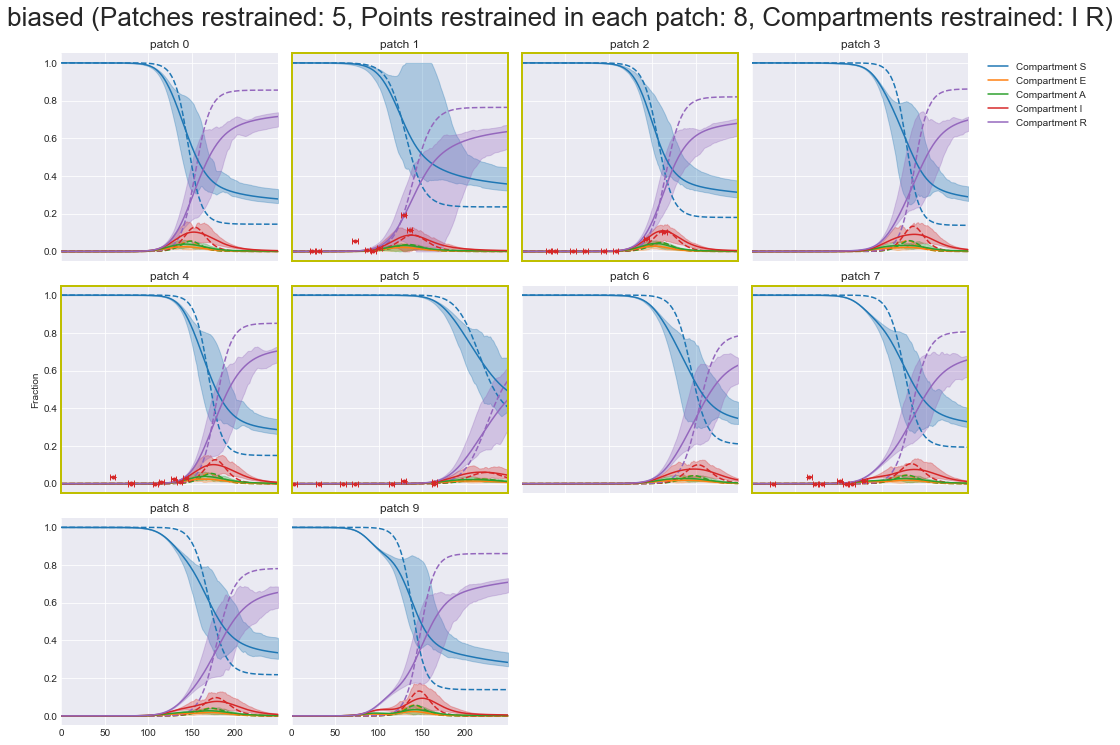

In [32]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

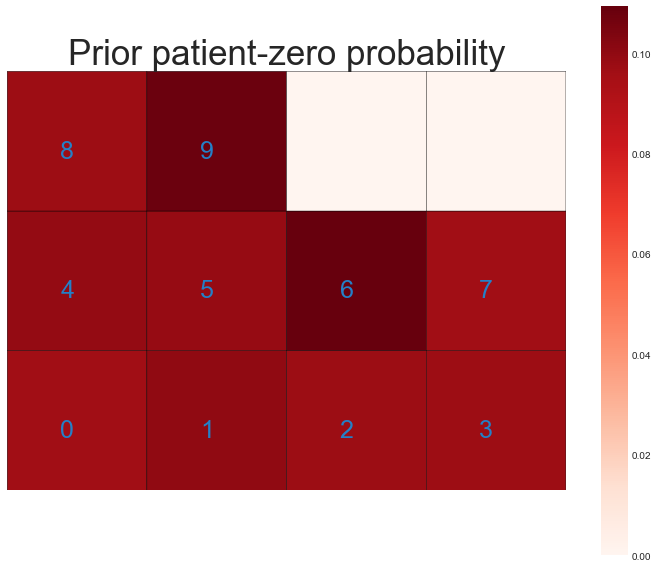

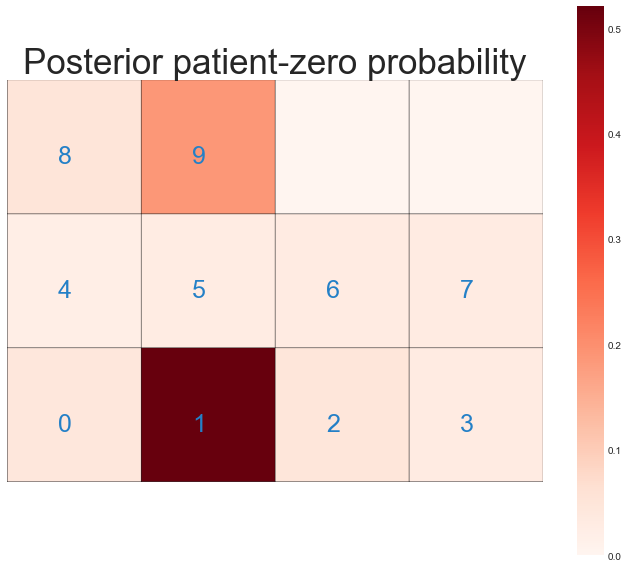

In [33]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

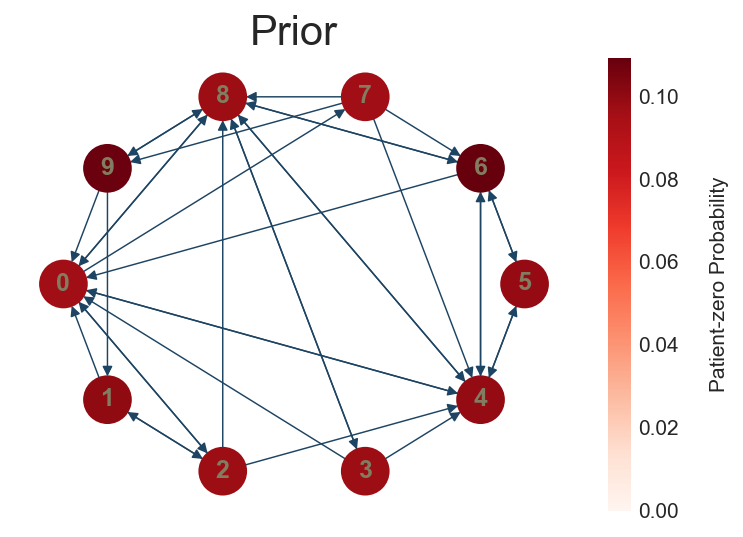

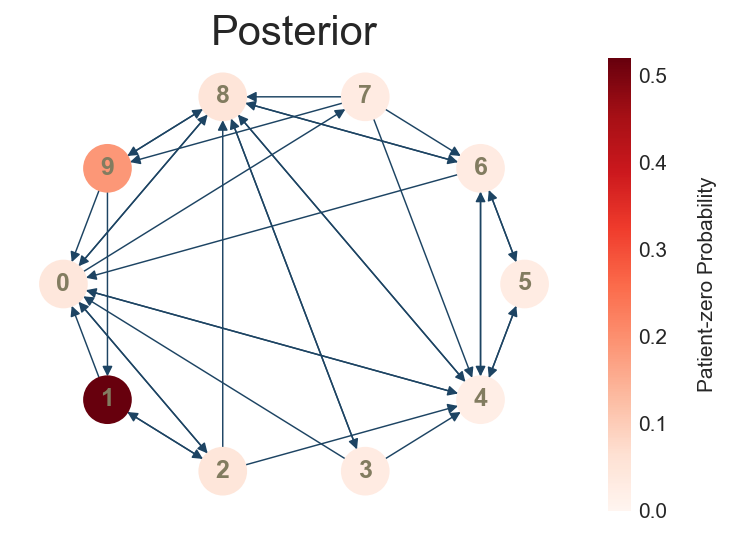

In [34]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [35]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.5208851119701545, 'patch 1'), (0.18786436223060876, 'patch 9'), (0.04908439914798344, 'patch 8'), (0.0475527643116108, 'patch 2'), (0.044762301436229945, 'patch 0')]


# Case 4

3.3

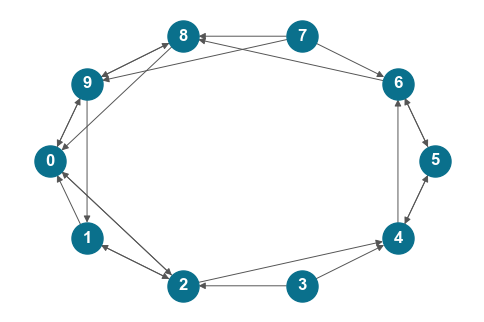

In [36]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


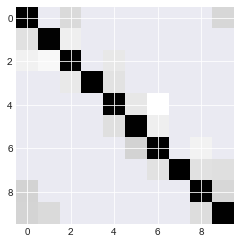

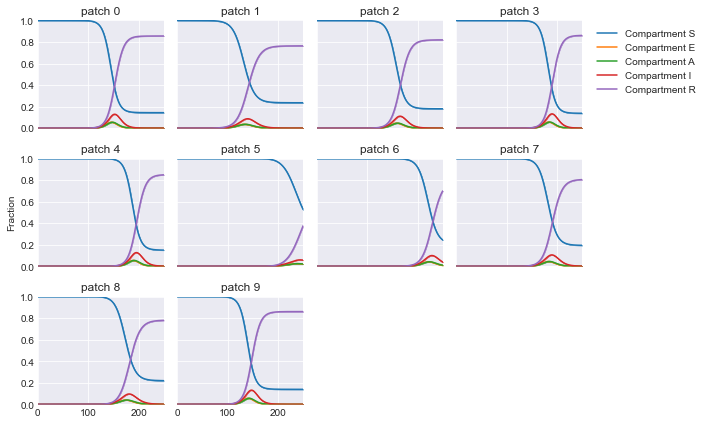

In [37]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area,
                                 mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [0, 180]
73 1.2166316e-05 0.02059087616797967
24 2.10714e-08 0.0
45 3.8359573e-07 0.0
171 0.098825455 0.12987031831288529
3 6.4674416e-12 0.0
94 0.00023259629 0.006612143804923939
52 1.3424786e-06 0.05080240091596692
108 0.0012012471 0.0
66 1.6818269e-05 0.0
108 0.0039054563 0.0
45 9.833207e-07 0.022482624060447667
143 0.12274196 0.14725816665349853
143 0.30952576 0.286378095634612
59 9.033357e-06 0.0
129 0.077034175 0.05699051098187169
87 0.00037693922 0.0
10 1.4652303e-15 0.010903400896386924
150 8.005891e-05 0.015879355180231935
80 5.106817e-09 0.00398679268126183
115 7.56298e-07 0.0
45 1.6275913e-11 0.0
24 1.2077157e-13 0.02486638768922387
101 1.3874296e-07 0.016253619585142855
108 3.7689475e-07 0.011745564482743043
171 0.047788728 0.024236148778883224
115 8.051841e-05 0.0
164 0.026089922 0.06118964466850725
38 1.152579e-09 0.0
164 0.047593206 0.06339743149412794
45 3.959913e-09 0.0022145412544068805
3 0.0 0.021558149521530307
94 6.404715e-06 

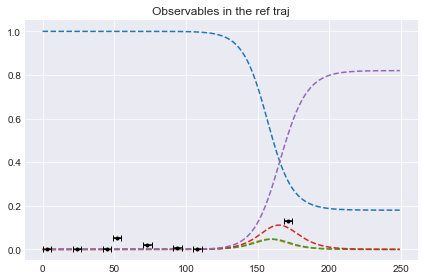

In [38]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.08s/it]


Plotting 10 patches in a 3 x 4 grid


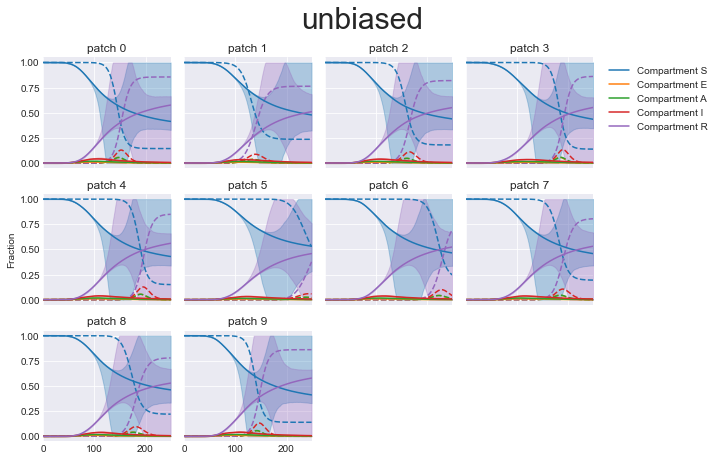

In [39]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0090 - weight-entropy: 6.9219
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 6.8748
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 6.8189
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 6.7768
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 6.7481
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.7288
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.7156
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.7069
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 6.7008
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3689
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3566
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3456
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3362
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3263
Epoch 84/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3156
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.3026
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2960
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2837
Epoch 88/500
8/8 [==============================] - 0s 2ms/step - loss: 0.001

Epoch 153/500
8/8 [==============================] - 0s 2ms/step - loss: 6.3085e-04 - weight-entropy: 5.5847
Epoch 154/500
8/8 [==============================] - 0s 2ms/step - loss: 6.2374e-04 - weight-entropy: 5.5428
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 5.7358e-04 - weight-entropy: 5.5164
Epoch 156/500
8/8 [==============================] - 0s 1ms/step - loss: 6.0040e-04 - weight-entropy: 5.5235
Epoch 157/500
8/8 [==============================] - 0s 1ms/step - loss: 5.6919e-04 - weight-entropy: 5.5142
Epoch 158/500
8/8 [==============================] - 0s 1ms/step - loss: 5.9435e-04 - weight-entropy: 5.5195
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 5.6765e-04 - weight-entropy: 5.4878
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 5.7813e-04 - weight-entropy: 5.5009
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0302e-04 - weight-entropy: 5.5109
Epoch 162/500
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 4.8364e-04 - weight-entropy: 5.0271
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 4.9631e-04 - weight-entropy: 5.0567
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 4.3300e-04 - weight-entropy: 5.0261
Epoch 231/500
8/8 [==============================] - 0s 2ms/step - loss: 4.6485e-04 - weight-entropy: 4.9981
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4618e-04 - weight-entropy: 5.0394
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4992e-04 - weight-entropy: 5.0237
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 5.0648e-04 - weight-entropy: 5.0659
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4514e-04 - weight-entropy: 5.0390
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 4.4814e-04 - weight-entropy: 4.9900
Epoch 237/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.8867e-04 - weight-entropy: 4.6893
Epoch 304/500
8/8 [==============================] - 0s 2ms/step - loss: 4.5077e-04 - weight-entropy: 4.9084
Epoch 305/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0893e-04 - weight-entropy: 4.7609
Epoch 306/500
8/8 [==============================] - 0s 2ms/step - loss: 4.7430e-04 - weight-entropy: 4.8570
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8045e-04 - weight-entropy: 4.6906
Epoch 308/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1776e-04 - weight-entropy: 4.7520
Epoch 309/500
8/8 [==============================] - 0s 2ms/step - loss: 4.3250e-04 - weight-entropy: 4.8001
Epoch 310/500
8/8 [==============================] - 0s 2ms/step - loss: 4.3071e-04 - weight-entropy: 4.6782
Epoch 311/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9629e-04 - weight-entropy: 4.7208
Epoch 312/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 4.0447e-04 - weight-entropy: 4.6293
Epoch 379/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1961e-04 - weight-entropy: 4.5708
Epoch 380/500
8/8 [==============================] - 0s 2ms/step - loss: 5.0797e-04 - weight-entropy: 4.7683
Epoch 381/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9039e-04 - weight-entropy: 4.6032
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7310e-04 - weight-entropy: 4.5406
Epoch 383/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0054e-04 - weight-entropy: 4.5469
Epoch 384/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7623e-04 - weight-entropy: 4.6140
Epoch 385/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8983e-04 - weight-entropy: 4.5236
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 4.8476e-04 - weight-entropy: 4.7241
Epoch 387/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.9138e-04 - weight-entropy: 4.5291
Epoch 454/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7885e-04 - weight-entropy: 4.4495
Epoch 455/500
8/8 [==============================] - 0s 2ms/step - loss: 4.6780e-04 - weight-entropy: 4.5931
Epoch 456/500
8/8 [==============================] - 0s 2ms/step - loss: 3.6986e-04 - weight-entropy: 4.3838
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4836e-04 - weight-entropy: 4.4587
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4078e-04 - weight-entropy: 4.3711
Epoch 459/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8338e-04 - weight-entropy: 4.4947
Epoch 460/500
8/8 [==============================] - 0s 1ms/step - loss: 3.5076e-04 - weight-entropy: 4.3738
Epoch 461/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7893e-04 - weight-entropy: 4.4533
Epoch 462/500
8/8 [==============

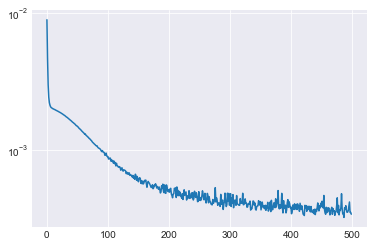

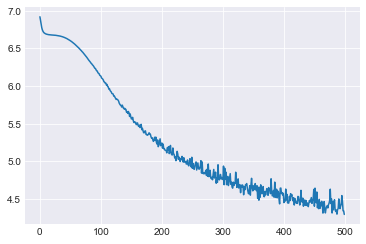

In [40]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


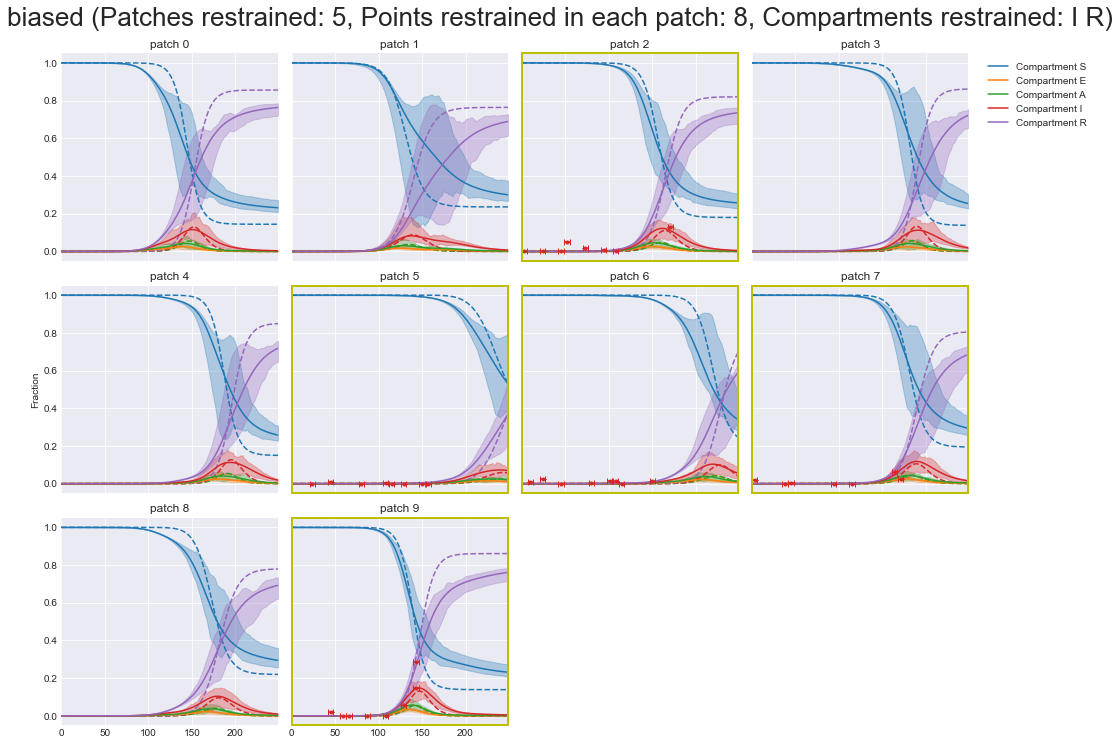

In [41]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

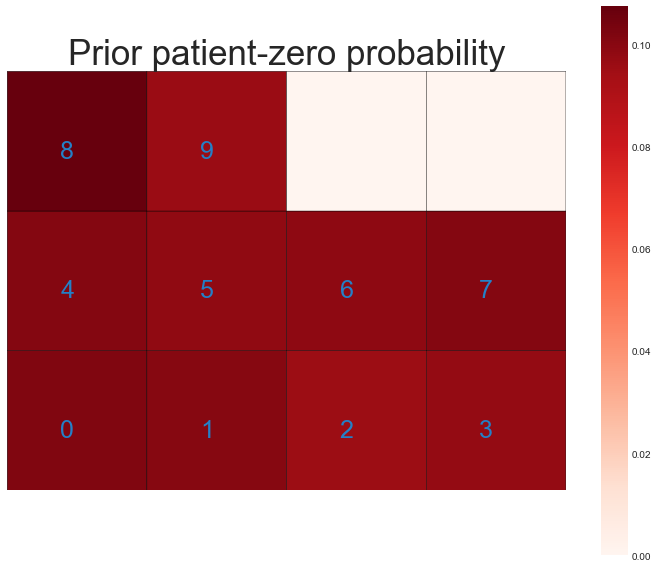

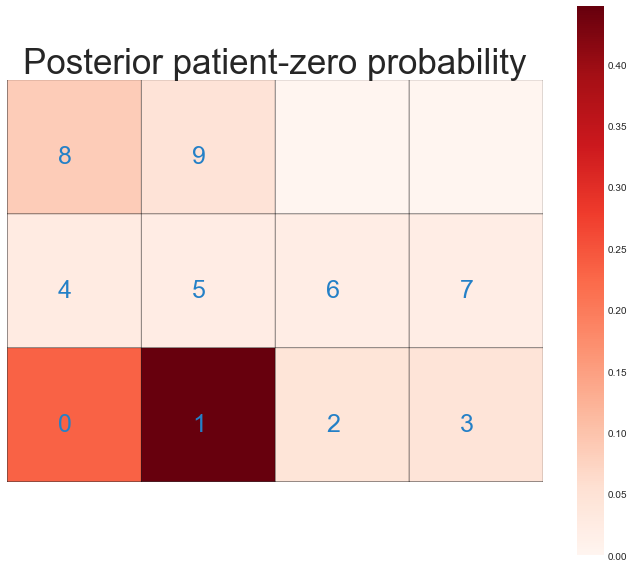

In [42]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


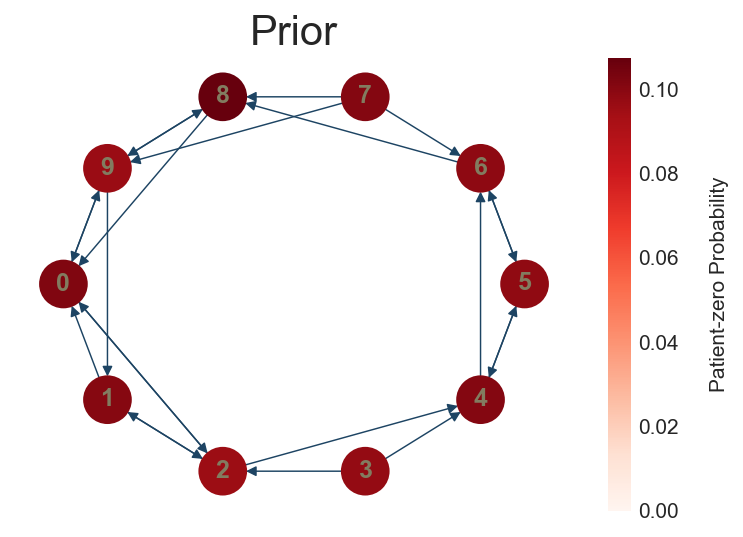

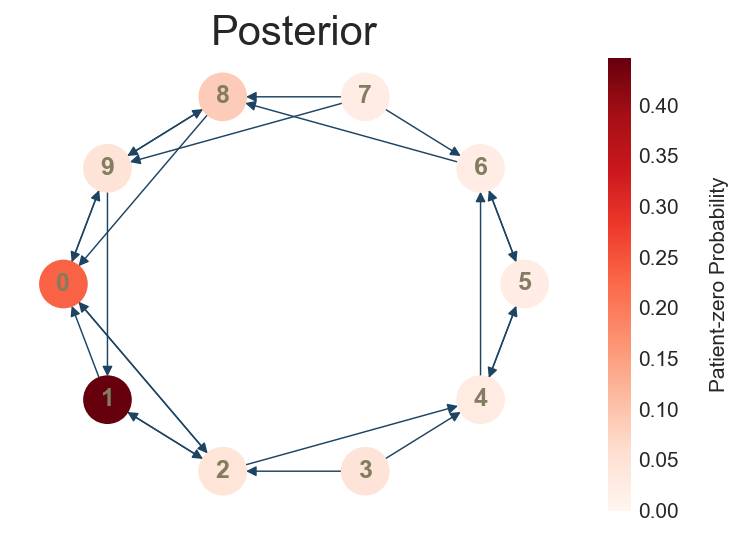

In [43]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [44]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.447239668614176, 'patch 1'), (0.2336170075714713, 'patch 0'), (0.086419174584818, 'patch 8'), (0.04778950286190148, 'patch 9'), (0.04588157413308569, 'patch 3')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

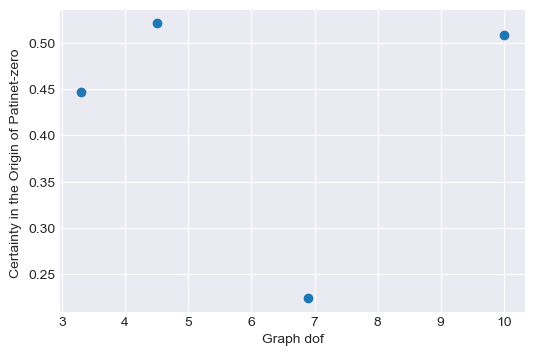

In [45]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')